In [3]:
# read original data
import pandas as pd

sort_df = pd.read_csv('data/sort.tsv', sep='\t')
grep_df = pd.read_csv('data/grep.tsv', sep='\t')
sgd_df = pd.read_csv('data/sgd.tsv', sep='\t')
kmeans_df = pd.read_csv('data/kmeans.tsv', sep='\t')
pagerank_df = pd.read_csv('data/pagerank.tsv', sep='\t')

In [4]:
# gen. sample data
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality

def generate_sample_data(orginal_data):

    configuration = {'enforce_min_max_values': True, 'enforce_rounding': True, 'epochs': 1500, 'batch_size': 200, 'compress_dims': [256, 256], 'decompress_dims': [256, 256], 'embedding_dim': 256, 'l2scale': 0.0001, 'loss_factor': 2}

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=orginal_data)
    metadata.validate()

    synthesizer = TVAESynthesizer(
            metadata=metadata,
            enforce_min_max_values=configuration['enforce_min_max_values'],
            epochs=configuration['epochs'],
            batch_size=configuration['batch_size'],
            compress_dims=configuration['compress_dims'],
            decompress_dims=configuration['decompress_dims'],
            embedding_dim=configuration['embedding_dim'],
            l2scale=configuration['l2scale'],
            loss_factor=configuration['loss_factor']
        )

    synthesizer.fit(orginal_data)
    # sample data will be used for training, original data for testing with a 90/10 split
    # therefore we create 9x more sample data than original data
    sample_size = len(orginal_data)*9
    synthetic_data = synthesizer.sample(sample_size)
    return synthetic_data

sort_sample_df = generate_sample_data(sort_df)
grep_sample_df = generate_sample_data(grep_df)
sgd_sample_df = generate_sample_data(sgd_df)
kmeans_sample_df = generate_sample_data(kmeans_df)
page_rank_sample_df = generate_sample_data(pagerank_df)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def get_training_data(df, features, filters):
    # Get medians
    g = df.groupby(by=['instance_count','machine_type']+features)
    df = pd.DataFrame(g.median().to_records())
    # Apply filters
    # e.g. only for one machine type each, the full c3o-experiments were conducted
    # No full cartesian product!
    for k, s, v in filters:
        if s == '==': df = df[df[k] == v]
        if s == '>' : df = df[df[k] >  v]
    X = df[['instance_count'] + features]
    y = (df[['gross_runtime']]).squeeze()
    return X, y

# sample data is training data
# Sort
sort_X_train, sort_y_train = get_training_data(sort_sample_df, 
                                               ['data_size_MB'], 
                                               [('machine_type', '==', 'c4.2xlarge'),('line_length', '==', 100)])
sort_X_test, sort_y_test = get_training_data(sort_df,
                                             ['data_size_MB'], 
                                             [('machine_type', '==', 'c4.2xlarge'),('line_length', '==', 100)])

# Grep
grep_X_train, grep_y_train = get_training_data(grep_sample_df,
                                               ['data_size_MB', 'p_occurrence'],
                                               [('machine_type', '==', 'm4.2xlarge')])
grep_X_test, grep_y_test = get_training_data(grep_df,
                                             ['data_size_MB', 'p_occurrence'],
                                             [('machine_type', '==', 'm4.2xlarge')])

# SGDLR
sgd_X_train, sgd_y_train = get_training_data(sgd_sample_df,
                                             ['observations', 'features', 'iterations'],
                                             [('machine_type', '==', 'r4.2xlarge'),
                                              ('instance_count', '>', 2)])
sgd_X_test, sgd_y_test = get_training_data(sgd_df,
                                           ['observations', 'features', 'iterations'],
                                           [('machine_type', '==', 'r4.2xlarge'),
                                            ('instance_count', '>', 2)])

# K-Means
kmeans_X_train, kmeans_y_train = get_training_data(kmeans_sample_df,
                                                   ['observations', 'features', 'k'],
                                                   [('machine_type', '==', 'r4.2xlarge'),
                                                    ('instance_count', '>', 2)])
kmeans_X_test, kmeans_y_test = get_training_data(kmeans_df,
                                                 ['observations', 'features', 'k'],
                                                 [('machine_type', '==', 'r4.2xlarge'),
                                                  ('instance_count', '>', 2)])

# Page Rank
pagerank_X_train, pagerank_y_train = get_training_data(page_rank_sample_df,
                                                       ['links', 'pages', 'convergence_criterion'],
                                                       [('machine_type', '==', 'r4.2xlarge')])
pagerank_X_test, pagerank_y_test = get_training_data(pagerank_df,
                                                     ['links', 'pages', 'convergence_criterion'],
                                                     [('machine_type', '==', 'r4.2xlarge')])


In [6]:
# for better traceability 
sort_X = sort_X_test
sort_y = sort_y_test

grep_X = grep_X_test
grep_y = grep_y_test

sgd_X = sgd_X_test
sgd_y = sgd_y_test

kmeans_X = kmeans_X_test
kmeans_y = kmeans_y_test

pagerank_X = pagerank_X_test
pagerank_y = pagerank_y_test

In [7]:
sort_X_train.head()

,instance_count,data_size_MB
1,2,9531
5,2,9538
7,2,9541
9,2,9555
11,2,9562


In [8]:
sort_y_train.head()

1     357.0
5     354.0
7     339.0
9     406.0
11    485.0
Name: gross_runtime, dtype: float64

In [9]:
sort_X_test.head()

,instance_count,data_size_MB
1,2,9630
2,2,11556
3,2,13482
4,2,15408
5,2,17334


In [10]:
sort_y_test.head()

1    368.0
2    436.0
3    496.0
4    590.0
5    668.0
Name: gross_runtime, dtype: float64

In [11]:
# init models
from models import OptimisticGradientBoosting, ErnestModel, BasicOptimisticModel, GradientBoosting

# default models
# GradientBoostingRegressor 
gb = GradientBoosting()
# Model for performance predictions using 'nnls', see [11]
em = ErnestModel()

# custom models
# ibm & ssm: GradientBoosting
ogb = OptimisticGradientBoosting() 
# ibm: LinearRegression, ssm: polyreg3
bom = BasicOptimisticModel()

models = [gb, em, ogb, bom]

In [12]:
from sklearn.model_selection import train_test_split

def pred_original(model, X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)
    errors = (y_hat - y_te).to_numpy()
    mu, sigma = errors.mean(), errors.std()
    return mu, sigma

def pred_sample(model, X_tr, X_te, y_tr, y_te):
    X_tr, X_te, y_tr, y_te = X_tr, X_te, y_tr, y_te
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_te)
    errors = (y_hat - y_te).to_numpy()
    mu, sigma = errors.mean(), errors.std()
    return mu, sigma

In [13]:
def print_bold(text):
    print('\033[1m' + text + '\033[0m')

def comapre_original_sample_for_all_models(file, X, y, X_tr, X_te, y_tr, y_te):
    print_bold(f'Comparing original and sample data for {file} \n')
    model_names = ['GradientBoosting', 'ErnestModel', 'OptimisticGradientBoosting','BasicOptimisticModel']
    results = []
    for i, model in enumerate(models):
        model_name = model_names[i]
        print(model_name)
        original_mu, orignal_sigma = pred_original(model, X, y)
        print(f"[ORIGINAL] Estimated mean runtime prediction error: {original_mu:.2f}s, " +\
            f"standard deviation: {orignal_sigma:.2f}s")
        sample_mu, sample_sigma = pred_sample(model, X_tr, X_te, y_tr, y_te)
        print(f"[SAMPLE] Estimated mean runtime prediction error: {sample_mu:.2f}s, " +\
            f"standard deviation: {sample_sigma:.2f}s \n")
        results.append({'file': file, 'model': model_name, 'original_mu': original_mu, 'sample_mu': sample_mu, 'orignal_sigma': orignal_sigma, 'sample_sigma': sample_sigma})
    
    return results
    

In [14]:
import warnings
results = []

# Sort
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    results_sort = comapre_original_sample_for_all_models('sort', sort_X, sort_y, sort_X_train, sort_X_test, sort_y_train, sort_y_test)
results.extend(results_sort)

Comparing original and sample data for sort 

GradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -7.94s, standard deviation: 49.89s
[SAMPLE] Estimated mean runtime prediction error: -14.09s, standard deviation: 48.13s 

ErnestModel
[ORIGINAL] Estimated mean runtime prediction error: 17.37s, standard deviation: 6.28s
[SAMPLE] Estimated mean runtime prediction error: -0.83s, standard deviation: 20.64s 

OptimisticGradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -1.32s, standard deviation: 14.17s
[SAMPLE] Estimated mean runtime prediction error: -3.17s, standard deviation: 31.27s 

BasicOptimisticModel
[ORIGINAL] Estimated mean runtime prediction error: 17.98s, standard deviation: 15.36s
[SAMPLE] Estimated mean runtime prediction error: 0.23s, standard deviation: 25.63s 



In [15]:
# Grep
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    results_grep = comapre_original_sample_for_all_models('grep', grep_X, grep_y, grep_X_train, grep_X_test, grep_y_train, grep_y_test)
results.extend(results_grep)

Comparing original and sample data for grep 

GradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -4.09s, standard deviation: 7.55s
[SAMPLE] Estimated mean runtime prediction error: 4.46s, standard deviation: 19.89s 

ErnestModel
[ORIGINAL] Estimated mean runtime prediction error: -5.94s, standard deviation: 55.07s
[SAMPLE] Estimated mean runtime prediction error: 11.10s, standard deviation: 49.11s 

OptimisticGradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -1.98s, standard deviation: 15.92s
[SAMPLE] Estimated mean runtime prediction error: 5.18s, standard deviation: 32.35s 

BasicOptimisticModel
[ORIGINAL] Estimated mean runtime prediction error: 8.96s, standard deviation: 14.78s
[SAMPLE] Estimated mean runtime prediction error: 5.22s, standard deviation: 33.23s 



In [16]:
# SGD
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    results_sgd = comapre_original_sample_for_all_models('sgd', sgd_X, sgd_y, sgd_X_train, sgd_X_test, sgd_y_train, sgd_y_test)
results.extend(results_sgd)

Comparing original and sample data for sgd 

GradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: 0.50s, standard deviation: 2.12s
[SAMPLE] Estimated mean runtime prediction error: 4.21s, standard deviation: 24.49s 

ErnestModel
[ORIGINAL] Estimated mean runtime prediction error: -23.46s, standard deviation: 45.28s
[SAMPLE] Estimated mean runtime prediction error: 15.31s, standard deviation: 42.48s 

OptimisticGradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: 13.41s, standard deviation: 18.92s
[SAMPLE] Estimated mean runtime prediction error: 12.76s, standard deviation: 36.40s 

BasicOptimisticModel
[ORIGINAL] Estimated mean runtime prediction error: 8.27s, standard deviation: 14.41s
[SAMPLE] Estimated mean runtime prediction error: 35.96s, standard deviation: 56.89s 



In [17]:
# K-Means
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    results_kmeans = comapre_original_sample_for_all_models('kmeans', kmeans_X, kmeans_y, kmeans_X_train, kmeans_X_test, kmeans_y_train, kmeans_y_test)
results.extend(results_kmeans)

Comparing original and sample data for kmeans 

GradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -0.77s, standard deviation: 9.51s
[SAMPLE] Estimated mean runtime prediction error: -7.14s, standard deviation: 31.91s 

ErnestModel
[ORIGINAL] Estimated mean runtime prediction error: 8.51s, standard deviation: 71.88s
[SAMPLE] Estimated mean runtime prediction error: 4.62s, standard deviation: 55.68s 

OptimisticGradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: 9.02s, standard deviation: 20.25s
[SAMPLE] Estimated mean runtime prediction error: 5.95s, standard deviation: 32.69s 

BasicOptimisticModel
[ORIGINAL] Estimated mean runtime prediction error: 1.00s, standard deviation: 20.69s
[SAMPLE] Estimated mean runtime prediction error: 13.74s, standard deviation: 30.96s 



In [18]:
# Page Rank
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    results_pagerank = comapre_original_sample_for_all_models('pagerank', pagerank_X, pagerank_y, pagerank_X_train, pagerank_X_test, pagerank_y_train, pagerank_y_test)
results.extend(results_pagerank)

Comparing original and sample data for pagerank 

GradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: -0.12s, standard deviation: 5.97s
[SAMPLE] Estimated mean runtime prediction error: -5.73s, standard deviation: 37.37s 

ErnestModel
[ORIGINAL] Estimated mean runtime prediction error: 44.13s, standard deviation: 102.98s
[SAMPLE] Estimated mean runtime prediction error: -13.70s, standard deviation: 122.93s 

OptimisticGradientBoosting
[ORIGINAL] Estimated mean runtime prediction error: 2.62s, standard deviation: 15.78s
[SAMPLE] Estimated mean runtime prediction error: -7.51s, standard deviation: 55.44s 

BasicOptimisticModel
[ORIGINAL] Estimated mean runtime prediction error: -9.69s, standard deviation: 56.84s
[SAMPLE] Estimated mean runtime prediction error: -7.15s, standard deviation: 63.02s 



In [19]:
print(results)

[{'file': 'sort', 'model': 'GradientBoosting', 'original_mu': -7.937977162211908, 'sample_mu': -14.090551040280584, 'orignal_sigma': 49.887382279253025, 'sample_sigma': 48.13280345100435}, {'file': 'sort', 'model': 'ErnestModel', 'original_mu': 17.37138738102196, 'sample_mu': -0.8274991895073064, 'orignal_sigma': 6.276745516869253, 'sample_sigma': 20.642632985918347}, {'file': 'sort', 'model': 'OptimisticGradientBoosting', 'original_mu': -1.3161925076159804, 'sample_mu': -3.1733918556424836, 'orignal_sigma': 14.172161400282366, 'sample_sigma': 31.271250241440825}, {'file': 'sort', 'model': 'BasicOptimisticModel', 'original_mu': 17.981176348434047, 'sample_mu': 0.2250652965657033, 'orignal_sigma': 15.35663937693036, 'sample_sigma': 25.630030196328214}, {'file': 'grep', 'model': 'GradientBoosting', 'original_mu': -4.0948863170349785, 'sample_mu': 4.456023436785906, 'orignal_sigma': 7.547215669251594, 'sample_sigma': 19.88611130349519}, {'file': 'grep', 'model': 'ErnestModel', 'original_m

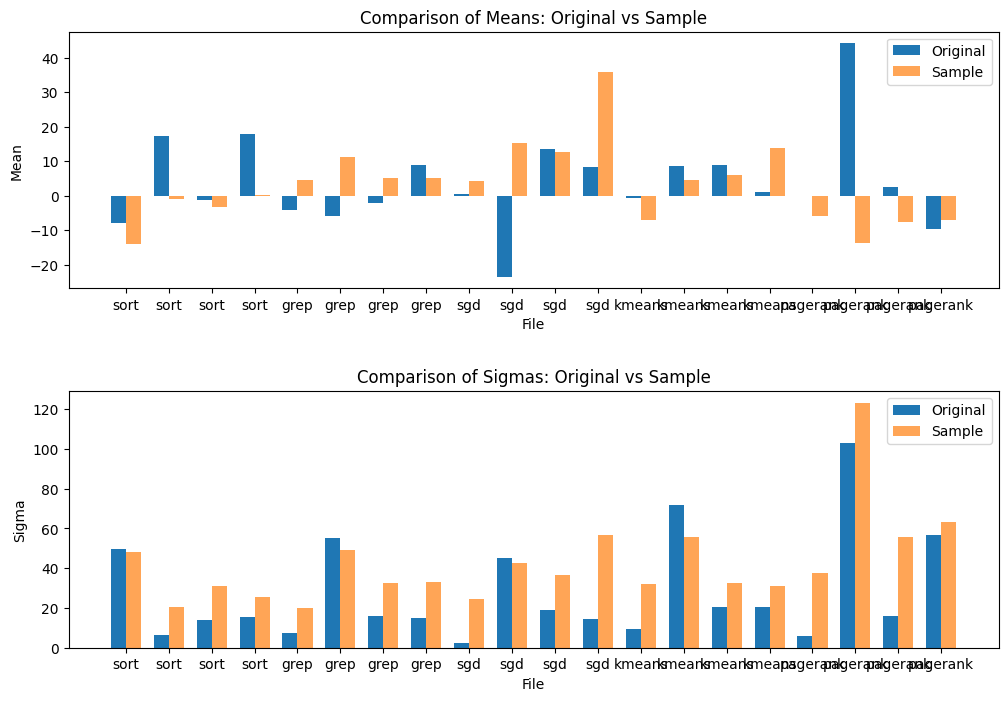

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_results(results):
    # Extract relevant data from the results
    models = []
    files = []
    original_means = []
    sample_means = []
    original_sigmas = []
    sample_sigmas = []

    for result in results:
        models.append(result['model'])
        files.append(result['file'])
        original_means.append(result['original_mu'])
        sample_means.append(result['sample_mu'])
        original_sigmas.append(result['orignal_sigma'])
        sample_sigmas.append(result['sample_sigma'])

    # Set up the figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot the means
    x = np.arange(len(results))
    width = 0.35

    ax1.bar(x - width/2, original_means, width, label='Original')
    ax1.bar(x + width/2, sample_means, width, label='Sample', alpha=0.7)

    ax1.set_xticks(x)
    ax1.set_xticklabels(files)
    ax1.set_xlabel('File')
    ax1.set_ylabel('Mean')
    ax1.set_title('Comparison of Means: Original vs Sample')
    ax1.legend()

    # Plot the sigmas
    ax2.bar(x - width/2, original_sigmas, width, label='Original')
    ax2.bar(x + width/2, sample_sigmas, width, label='Sample', alpha=0.7)

    ax2.set_xticks(x)
    ax2.set_xticklabels(files)
    ax2.set_xlabel('File')
    ax2.set_ylabel('Sigma')
    ax2.set_title('Comparison of Sigmas: Original vs Sample')
    ax2.legend()

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.4)

    # Show the plot
    plt.show()

# Usage
visualize_results(results)


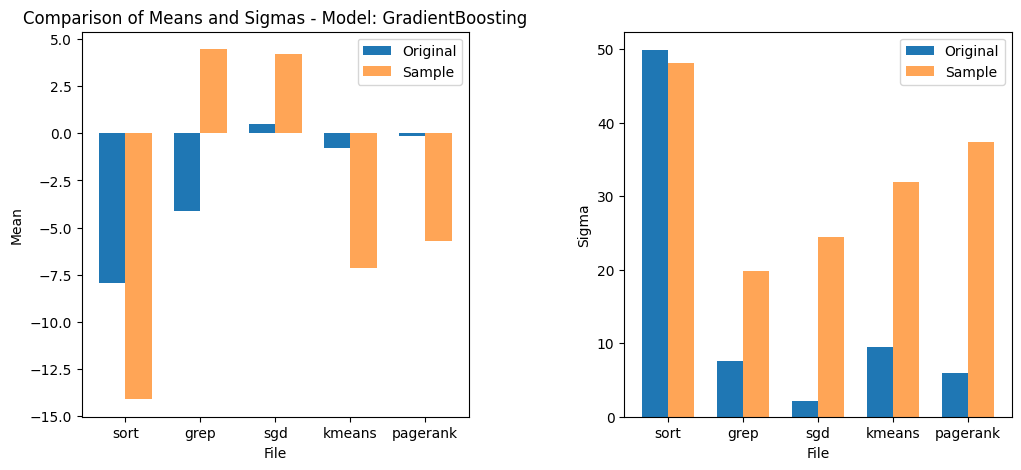

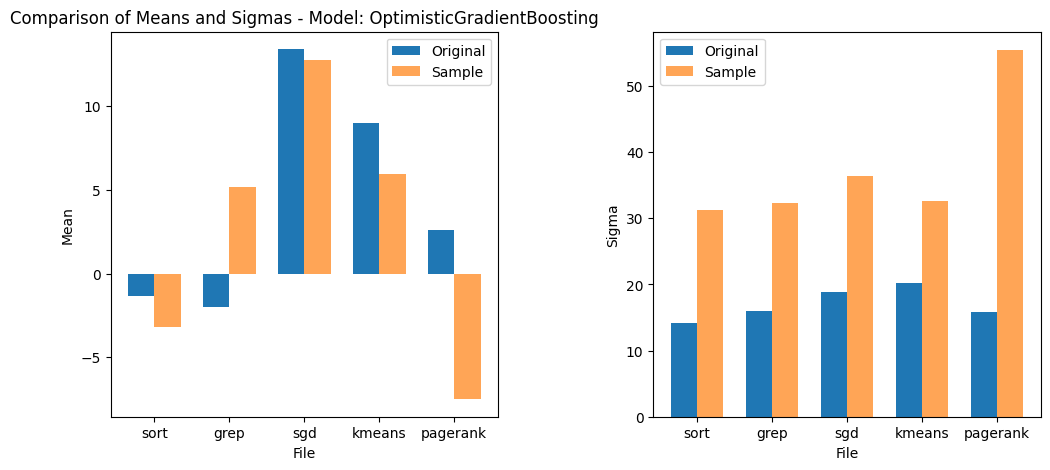

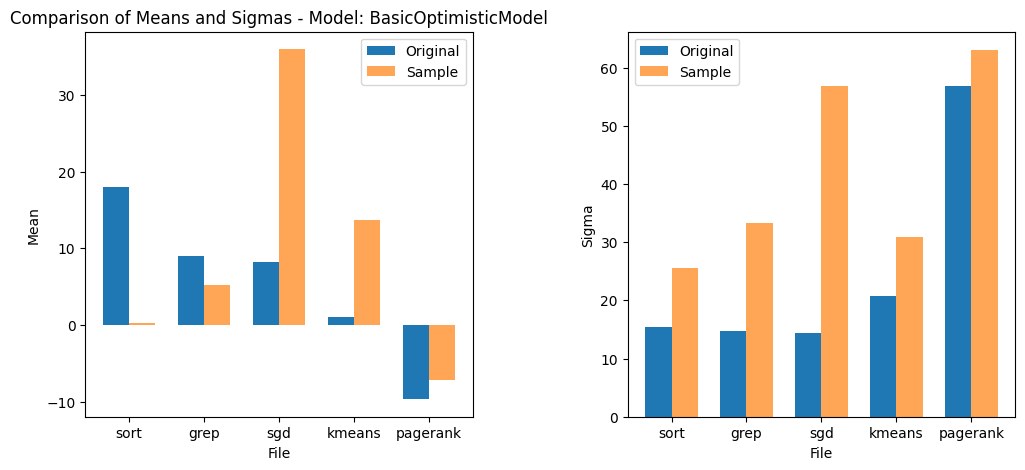

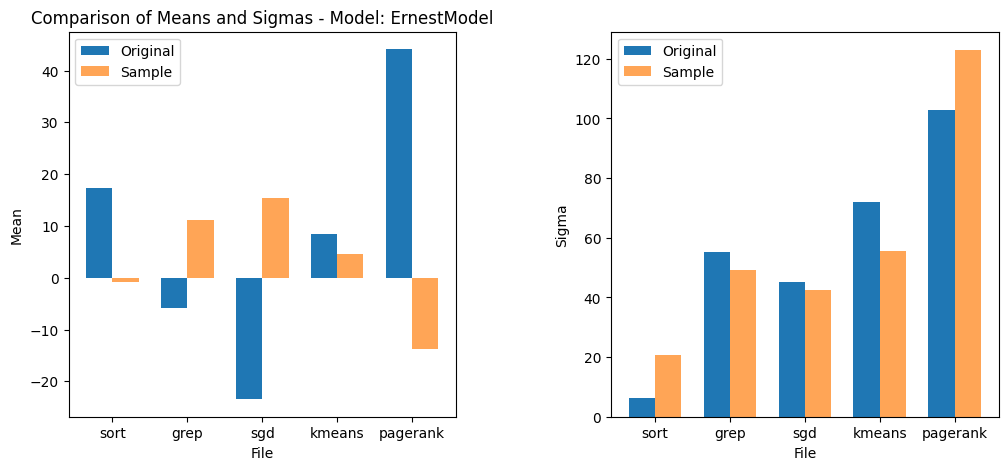

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_results(results):
    # Group results by model
    models = set(result['model'] for result in results)

    for model in models:
        # Filter results for the current model
        model_results = [result for result in results if result['model'] == model]

        # Extract relevant data
        files = [result['file'] for result in model_results]
        original_means = [result['original_mu'] for result in model_results]
        sample_means = [result['sample_mu'] for result in model_results]
        original_sigmas = [result['orignal_sigma'] for result in model_results]
        sample_sigmas = [result['sample_sigma'] for result in model_results]

        # Set up the figure and axes for the current model
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Plot the means
        x = np.arange(len(model_results))
        width = 0.35

        ax1.bar(x - width/2, original_means, width, label='Original')
        ax1.bar(x + width/2, sample_means, width, label='Sample', alpha=0.7)

        ax1.set_xticks(x)
        ax1.set_xticklabels(files)
        ax1.set_xlabel('File')
        ax1.set_ylabel('Mean')
        ax1.set_title(f'Comparison of Means and Sigmas - Model: {model}')
        ax1.legend()

        # Plot the sigmas
        ax2.bar(x - width/2, original_sigmas, width, label='Original')
        ax2.bar(x + width/2, sample_sigmas, width, label='Sample', alpha=0.7)

        ax2.set_xticks(x)
        ax2.set_xticklabels(files)
        ax2.set_xlabel('File')
        ax2.set_ylabel('Sigma')
        ax2.legend()

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.4)

        # Show the plot for the current model
        plt.show()

# Usage
visualize_results(results)


In [22]:
for item in results:
    file = item['file']
    model = item['model']
    original_mu = item['original_mu']
    sample_mu = item['sample_mu']
    original_sigma = item['orignal_sigma']
    sample_sigma = item['sample_sigma']

    mu_difference = original_mu - sample_mu
    sigma_difference = original_sigma - sample_sigma

    print(f"File: {file}, Model: {model}")
    print(f"Mu Difference: {mu_difference}")
    print(f"Sigma Difference: {sigma_difference}")
    print()


File: sort, Model: GradientBoosting
Mu Difference: 6.152573878068676
Sigma Difference: 1.7545788282486754

File: sort, Model: ErnestModel
Mu Difference: 18.198886570529268
Sigma Difference: -14.365887469049094

File: sort, Model: OptimisticGradientBoosting
Mu Difference: 1.8571993480265032
Sigma Difference: -17.09908884115846

File: sort, Model: BasicOptimisticModel
Mu Difference: 17.756111051868345
Sigma Difference: -10.273390819397854

File: grep, Model: GradientBoosting
Mu Difference: -8.550909753820886
Sigma Difference: -12.338895634243597

File: grep, Model: ErnestModel
Mu Difference: -17.033119732428403
Sigma Difference: 5.957201023123972

File: grep, Model: OptimisticGradientBoosting
Mu Difference: -7.157013909827534
Sigma Difference: -16.42649836745453

File: grep, Model: BasicOptimisticModel
Mu Difference: 3.7404291564863676
Sigma Difference: -18.45157359341317

File: sgd, Model: GradientBoosting
Mu Difference: -3.7103809102131704
Sigma Difference: -22.36774648389259

File: sg

In [27]:
import statistics

mu_difference_by_model = {}
sigma_difference_by_model = {}

for item in results:
    file = item['file']
    model = item['model']
    original_mu = item['original_mu']
    sample_mu = item['sample_mu']
    original_sigma = item['orignal_sigma']
    sample_sigma = item['sample_sigma']

    mu_difference = abs(original_mu - sample_mu)
    sigma_difference = abs(original_sigma - sample_sigma)

    if model not in mu_difference_by_model:
        mu_difference_by_model[model] = []
    if model not in sigma_difference_by_model:
        sigma_difference_by_model[model] = []

    mu_difference_by_model[model].append(mu_difference)
    sigma_difference_by_model[model].append(sigma_difference)

for model in mu_difference_by_model:
    mu_avg_abs_difference = statistics.mean(mu_difference_by_model[model])
    sigma_avg_abs_difference = statistics.mean(sigma_difference_by_model[model])

    print(f"Model: {model}")
    print(f"Average Absolute Mu Difference: {mu_avg_abs_difference}")
    print(f"Average Absolute Sigma Difference: {sigma_avg_abs_difference}")
    print()


Model: GradientBoosting
Average Absolute Mu Difference: 6.077334863077381
Average Absolute Sigma Difference: 18.052586633154693

Model: ErnestModel
Average Absolute Mu Difference: 27.14498405703239
Average Absolute Sigma Difference: 11.854563203348404

Model: OptimisticGradientBoosting
Average Absolute Mu Difference: 4.572871753276148
Average Absolute Sigma Difference: 20.621368424062105

Model: BasicOptimisticModel
Average Absolute Mu Difference: 12.892218131972644
Average Absolute Sigma Difference: 17.530834996868602

